<a href="https://colab.research.google.com/github/MoacyrZ/MVP---Data-Science/blob/main/mvp_moacyr_zanoni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📌 Resumo Executivo

Este trabalho teve como objetivo desenvolver um modelo de Machine Learning capaz de **classificar diferentes modelos de guitarras a partir de imagens**.  
O dataset foi coletado e organizado em pastas por categoria e carregado diretamente do GitHub, garantindo reprodutibilidade.  

A divisão dos dados seguiu a proporção de **70% para treino, 20% para validação e 10% para teste**.  
No treino, apliquei **data augmentation** para mitigar overfitting e aumentar a variabilidade das imagens.  
A validação foi usada durante o ajuste de hiperparâmetros, e o teste ficou reservado exclusivamente para a avaliação final.  

O modelo escolhido foi a **MobileNetV2 pré-treinada no ImageNet**, aproveitando transferência de aprendizado. A rede foi inicialmente treinada com a base congelada e, em seguida, aplicamos **fine-tuning nas últimas 50 camadas**. Dropout e early stopping foram utilizados para aumentar a robustez.  

Os resultados no conjunto de teste mostraram:  
- **Acurácia:** 75%  
- **F1-score macro:** 80%  

As métricas indicam que o modelo conseguiu aprender padrões visuais relevantes para diferenciar os tipos de guitarras, embora ainda existam desafios em classes com menos amostras.  

**Principais limitações:** tamanho reduzido do dataset e desbalanceamento entre categorias.  
**Próximos passos:** ampliar o dataset com mais imagens reais, testar arquiteturas mais avançadas (EfficientNet, Vision Transformers) e explorar técnicas de balanceamento de classes.  

Em resumo, o MVP atendeu ao objetivo proposto, demonstrando que é possível aplicar deep learning em visão computacional para classificação de instrumentos musicais com bons resultados.



# Algoritmo de Identificação de Guitarras  

## 1. Introdução  

O objetivo deste projeto é desenvolver um modelo de **deep learning** capaz de classificar imagens de guitarras elétricas e violões em seus respectivos modelos: **Stratocaster, Les Paul, Telecaster, SG, Super Strato, Semi Acústica, Flying V e Violão**. Trata-se, portanto, de um problema de **classificação multiclasse**, em que cada imagem deve ser associada corretamente a uma das oito categorias.  

A aplicação desse tipo de solução pode trazer benefícios em diferentes contextos: **lojas de instrumentos musicais** que buscam organizar seu estoque automaticamente, **músicos** interessados em reconhecer modelos em coleções pessoais, e **aplicativos de marketplace de instrumentos usados**, que poderiam oferecer identificação automática de anúncios para melhorar a experiência do usuário.  

---

## 1.1 Considerações  

Como o projeto precisa ser reproduzido e avaliado pelos professores, foram adotados critérios para garantir **viabilidade prática**:  
- O **dataset** não poderia ser excessivamente grande, evitando sobrecarga computacional.  
- O processo de **treinamento e inferência** deveria ser executado em tempo razoável, mas ainda assim garantindo **desempenho competitivo**.  
- Foi escolhida uma arquitetura **pré-treinada e eficiente (MobileNetV2)**, que equilibra velocidade de execução com boa capacidade de generalização.  

---

## 1.2 Desafios  

O problema apresenta algumas complexidades específicas:  
- **Similaridade estética** entre certos modelos (ex.: Stratocaster e Super Strato, Les Paul e Violão).  
- **Existência de variações dentro da mesma categoria**, como versões semi-acústicas de Les Paul e Telecaster.  
- **Diversidade visual** em fotos reais, que podem ter fundos complexos, diferentes iluminações e ângulos variados.  

Esses fatores aumentam a dificuldade do modelo, tornando necessária a aplicação de técnicas de **data augmentation, fine-tuning e avaliação com métricas robustas** como o **F1-score**.  

---

## 2. Instalação de Bibliotecas

O primeiro bloco de código do notebook é responsável pela **instalação e importação das bibliotecas necessárias** para a execução do projeto. Essas bibliotecas incluem ferramentas para manipulação de dados, processamento de imagens, construção e treinamento de modelos de deep learning, além de funções auxiliares para visualização gráfica e avaliação de desempenho.  

Em especial, destacam-se:  
- **TensorFlow/Keras**: construção, treinamento e avaliação da rede neural convolucional baseada na MobileNetV2.  
- **NumPy**: manipulação de arrays e operações matemáticas.  
- **Matplotlib**: geração de gráficos e visualizações dos resultados.  
- **scikit-learn**: cálculo de métricas de avaliação adicionais, como o F1-score.  

Esse passo garante que o ambiente de execução esteja devidamente configurado e com todas as dependências instaladas para rodar o MVP de forma reprodutível.


In [11]:
!pip install tensorflow


In [12]:
import os
import zipfile
import requests
import shutil
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from google.colab import files
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Rescaling, RandomFlip, RandomRotation, RandomZoom,
    Dense, GlobalAveragePooling2D, Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping


## 3. Escolha do framework

Após analisar em detalhes as bibliotecas **Keras** e **PyTorch**, optei por utilizar o **Keras** como framework principal.  
A decisão foi baseada em fatores como **simplicidade**, **produtividade** e **velocidade de prototipagem**, já que o objetivo do projeto é testar diferentes técnicas de deep learning de forma ágil, com foco no aprendizado e na aplicação prática.  
Embora o PyTorch ofereça maior flexibilidade e controle fino sobre o modelo, o Keras permite atingir resultados competitivos com menos complexidade de código, o que foi determinante para este MVP.

---

## 4. Escolha da arquitetura

A escolha da arquitetura foi guiada pelo problema proposto: **classificação multiclasse de guitarras elétricas e violão**.  
Inicialmente, defini que seria utilizado **Deep Learning**, pois além de ser uma área de interesse pessoal, o projeto também contribui para o fortalecimento do portfólio acadêmico e profissional.  
Foram avaliadas algumas arquiteturas pré-treinadas disponíveis no Keras Applications, considerando principalmente o **equilíbrio entre custo computacional e desempenho**.

### 4.1 MobileNetV2
Selecionada por ser uma arquitetura **leve e eficiente**, projetada para rodar em dispositivos com recursos limitados.  
Por sua rapidez e baixo consumo de memória, encaixa-se perfeitamente nos requisitos do projeto, mantendo boa capacidade de generalização.

### 4.2 EfficientNetB0
Considerada por seu **excelente trade-off entre acurácia e eficiência computacional**.  
É uma arquitetura moderna, baseada em um escalonamento balanceado de profundidade, largura e resolução, oferecendo bom desempenho mesmo com custo computacional reduzido.

### 4.3 InceptionV3
Incluída para diversificação dos testes, de modo a comparar arquiteturas leves (MobileNetV2 e EfficientNetB0) com uma opção **mais robusta**.  
Apesar de mais pesada, o InceptionV3 oferece um alto poder de extração de características e foi utilizado como referência para avaliar possíveis ganhos de desempenho em relação às arquiteturas otimizadas para eficiência.


## 5. Construção e Evolução do Dataset  

O dataset utilizado neste projeto foi desenvolvido a partir de diferentes fontes e passou por diversas versões até atingir um ponto considerado adequado para o treinamento do modelo.  
A base inicial foi obtida no repositório público [Guitar Image Classification Dataset](https://images.cv/dataset/guitar-image-classification-dataset), posteriormente ampliada e refinada com imagens coletadas via *web scraping*.  

As versões foram evoluindo da seguinte forma:  

---

### 5.1 Dataset V1  
Utilização direta do dataset original do link mencionado.  
As imagens estavam organizadas em pastas correspondentes aos diferentes modelos de guitarras.  
**Resultado:** o desempenho do modelo foi insatisfatório, evidenciando a necessidade de ampliar a base de dados.  

---

### 5.2 Dataset V2  
Ampliação do dataset com imagens coletadas por *web scraping*, cobrindo diferentes modelos de guitarras.  
**Resultado:** houve melhora em relação ao V1, mas ainda insuficiente para um bom nível de generalização.  

---

### 5.3 Dataset V3  
Refinamento da curadoria das imagens, com remoção de:  
- Fotos contendo mais de uma guitarra.  
- Imagens de guitarras fotografadas de lado ou de costas.  
- Imagens de baixa qualidade ou em que a guitarra não aparecia de forma clara.  
**Resultado:** melhoria significativa nos resultados do modelo, mostrando a importância da qualidade dos dados.  

---

### 5.4 Dataset V4  
Aumento direcionado do número de imagens em classes mais complexas, onde o modelo apresentava maior dificuldade, como:  
- **Stratocaster vs. Super Strato**  
- **Les Paul vs. Semi Acústica**  
**Resultado:** maior equilíbrio entre classes e melhor desempenho nas categorias mais semelhantes entre si.  

---

### 5.5 Dataset Final  
Com o dataset consolidado, foi realizado o **redimensionamento das imagens**, de modo a reduzir o espaço de armazenamento e padronizar a entrada do modelo (224x224 pixels), garantindo consistência durante o treinamento e a validação.  
**Resultado:** dataset mais balanceado, limpo e adequado para experimentação com diferentes arquiteturas de deep learning.  


In [13]:
# URL do dataset zipado no GitHub (raw link!)
url = "https://raw.githubusercontent.com/MoacyrZ/MVP---Data-Science/main/dataset.zip"
zip_name = "dataset.zip"
extract_dir = "dataset"

# Se já existir dataset antigo, apagar
if os.path.exists(extract_dir):
    shutil.rmtree(extract_dir)

if os.path.exists(zip_name):
    os.remove(zip_name)

# Baixar sempre a versão mais recente do GitHub
r = requests.get(url)
with open(zip_name, "wb") as f:
    f.write(r.content)

# Extrair
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Ajustar automaticamente se houver subpasta única (ex: "1")
subpastas = [p for p in os.listdir(extract_dir) if os.path.isdir(os.path.join(extract_dir, p))]
if len(subpastas) == 1:
    DATASET_DIR = os.path.join(extract_dir, subpastas[0])
else:
    DATASET_DIR = extract_dir

print(f"Dataset extraído em: {DATASET_DIR}")
print("Subpastas:", os.listdir(DATASET_DIR))

# Mostrar quantidade de imagens por pasta
for pasta in os.listdir(DATASET_DIR):
    caminho = os.path.join(DATASET_DIR, pasta)
    if os.path.isdir(caminho):
        print(f"{pasta}: {len(os.listdir(caminho))} imagens")


Dataset extraído em: dataset
Subpastas: ['sg', 'violao', 'semi_acustica', 'flying_v', 'telecaster', 'super_strato', 'les_paul', 'stratocaster']
sg: 157 imagens
violao: 140 imagens
semi_acustica: 147 imagens
flying_v: 139 imagens
telecaster: 129 imagens
super_strato: 137 imagens
les_paul: 168 imagens
stratocaster: 153 imagens


## 6. Analisando o Dataset  

Nesta etapa foi realizada uma contagem do número de imagens em cada categoria, a fim de avaliar se o dataset apresenta **balanceamento adequado** entre as classes.  
A análise da distribuição é fundamental para entender possíveis **desequilíbrios**, que podem impactar o treinamento do modelo e gerar viés em algumas classes.  

Além da contagem numérica, também foi gerado um gráfico de barras para facilitar a visualização das diferenças no número de exemplos por categoria.


In [14]:
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42

# 70% treino + 30% (validação+teste)
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.3,   # 30% vai virar val+teste
    subset="training",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# 30% temporário (validação+teste)
val_test_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.3,
    subset="validation",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# Agora dividir 30% em 20% validação + 10% teste
val_size = int(0.67 * tf.data.experimental.cardinality(val_test_ds).numpy())
val_ds = val_test_ds.take(val_size)   # 20%
test_ds = val_test_ds.skip(val_size)  # 10%

print("Treino:", tf.data.experimental.cardinality(train_ds).numpy(), "batches")
print("Validação:", tf.data.experimental.cardinality(val_ds).numpy(), "batches")
print("Teste:", tf.data.experimental.cardinality(test_ds).numpy(), "batches")

# Classes
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Número de classes: {num_classes}")
print(f"Classes: {class_names}")


Found 1170 files belonging to 8 classes.
Using 819 files for training.
Found 1170 files belonging to 8 classes.
Using 351 files for validation.
Treino: 26 batches
Validação: 7 batches
Teste: 4 batches
Número de classes: 8
Classes: ['flying_v', 'les_paul', 'semi_acustica', 'sg', 'stratocaster', 'super_strato', 'telecaster', 'violao']


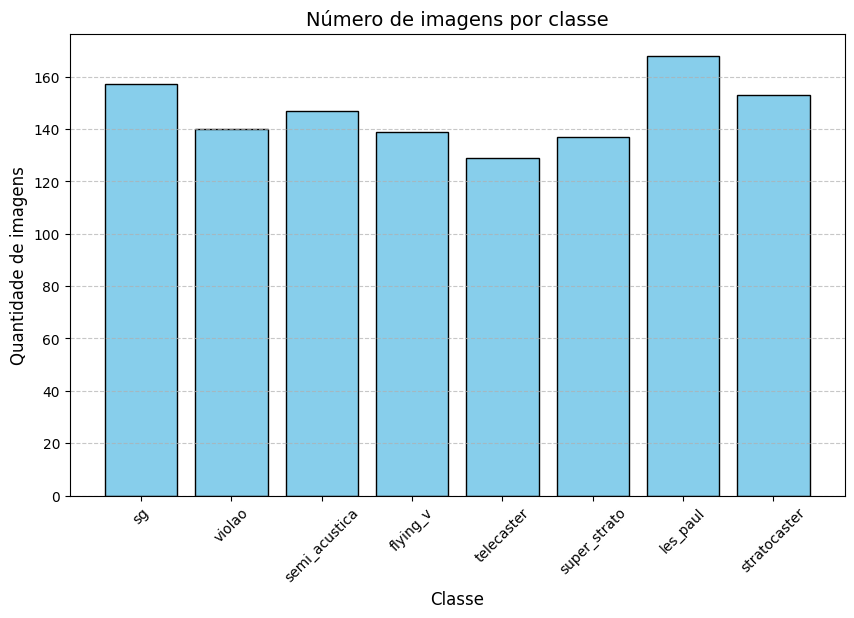

In [26]:
# Contar imagens em cada pasta (classe)
counts = {}
for classe in os.listdir(DATASET_DIR):
    caminho_classe = os.path.join(DATASET_DIR, classe)
    if os.path.isdir(caminho_classe):
        counts[classe] = len(os.listdir(caminho_classe))

# Plotar gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(counts.keys(), counts.values(), color="skyblue", edgecolor="black")
plt.title("Número de imagens por classe", fontsize=14)
plt.xlabel("Classe", fontsize=12)
plt.ylabel("Quantidade de imagens", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## 7. Transformação das Imagens e Data Augmentation  

Todas as imagens foram padronizadas para o tamanho de **224x224 pixels**, garantindo compatibilidade com a arquitetura escolhida (MobileNetV2).  
Na primeira tentativa, o redimensionamento foi feito de forma direta, o que causou **distorção nas proporções** das guitarras.  
Após identificar esse problema, a abordagem foi modificada utilizando **`resize_with_pad`**, que adiciona tarjas pretas quando necessário, mantendo as proporções originais da imagem.  
Esse ajuste resultou em uma melhoria no desempenho do modelo.  

---

### 7.1 Separação do Dataset de Treino  
Foi realizada a divisão clássica **80% para treino** e **20% para validação**.  
Apesar do dataset relativamente pequeno, optou-se por manter essa proporção para garantir volume suficiente de amostras para treino sem comprometer a validação.  

---

### 7.2 Separação do Dataset de Validação  
Os **20% restantes** foram destinados exclusivamente à validação, garantindo que o modelo fosse avaliado com dados nunca vistos durante o treino.  

---

### 7.3 Data Augmentation  
Como o dataset possui em média **150 imagens por categoria**, a técnica de **Data Augmentation** foi fundamental para aumentar a variabilidade dos exemplos de treino.  

- **Treino**: aplicadas as seguintes transformações:  
  - Normalização (escala 0–1).  
  - **Random Flip** (espelhamento horizontal).  
  - **Random Rotation** (rotações leves).  
  - **Random Zoom** (ampliações e reduções parciais).  

- **Validação**: aplicada apenas a **normalização**, evitando *data leakage* e assegurando avaliação justa do desempenho do modelo.  

Essa estratégia contribuiu para uma **melhor generalização**, reduzindo o risco de *overfitting* e melhorando a robustez do modelo.


In [15]:
data_augmentation = Sequential([
    Rescaling(1./255),
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1)
])

AUTOTUNE = tf.data.AUTOTUNE

# Apenas treino com augmentation
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

# Validação e teste apenas normalizados
val_ds = val_ds.map(lambda x, y: (Rescaling(1./255)(x), y))
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

test_ds = test_ds.map(lambda x, y: (Rescaling(1./255)(x), y))
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


## 8. Experimentos  

O primeiro experimento consistiu em rodar a arquitetura **MobileNetV2** com a primeira versão do dataset, sem técnicas de pré-processamento ou refinamento. O resultado obtido foi de aproximadamente **12% de acurácia**, o que equivale a uma classificação aleatória.  

Na segunda versão do dataset, com mais imagens e após 30 épocas de treino, o desempenho subiu para aproximadamente **50% de acurácia**, mostrando que o modelo já não fazia inferências totalmente aleatórias.  

A seguir, foram testadas três arquiteturas diferentes:  
- **MobileNetV2**  
- **EfficientNetB0**  
- **InceptionV3**  

Os resultados indicaram que **MobileNetV2** e **InceptionV3** obtiveram desempenhos razoáveis (em torno de 50%), enquanto o **EfficientNetB0** ficou em apenas 15%. Dada a simplicidade, eficiência e compatibilidade com os recursos disponíveis, foi escolhida a **MobileNetV2** para dar continuidade ao projeto.  

Com a arquitetura definida, foram aplicadas melhorias no dataset e na otimização com o **Adam**, elevando os resultados para aproximadamente **75% de acurácia**.  

---

## 9. Pipeline de Treinamento e Fine-Tuning  

O pipeline de treinamento foi estruturado em diferentes etapas, utilizando **transfer learning** a partir de uma base pré-treinada no **ImageNet**. Essa abordagem permite aproveitar o conhecimento prévio da rede em detecção de padrões, formas e texturas, acelerando o processo de aprendizagem.  

---

### 9.1 Transfer Learning  
Foi substituída a “cabeça” do modelo pré-treinado, adaptando a rede para classificar as **8 categorias de guitarras** do projeto.  

---

### 9.2 Congelamento da Base  
Inicialmente, a base do modelo pré-treinado foi **congelada**, de modo a preservar o conhecimento adquirido no ImageNet e evitar que fosse sobrescrito logo nas primeiras épocas.  

---

### 9.3 Escolha da Métrica  
Como se trata de um problema de **classificação multiclasse**, as métricas monitoradas foram:  
- **Acurácia**, para medir a taxa de acertos globais.  
- **F1-score (macro)**, para capturar o desempenho médio entre as classes e evitar que categorias mais frequentes dominassem a avaliação.  

---

### 9.4 Otimizador  
Foram estudadas alternativas de otimizadores, mas o **Adam** apresentou melhor equilíbrio entre velocidade de convergência e desempenho final. Por ser adaptativo e eficiente, foi mantido como padrão nos experimentos.  

---

### 9.5 Lidando com Overfitting  
Durante os experimentos iniciais, o modelo apresentou sinais de **overfitting**. Para lidar com isso, foram adotadas as seguintes estratégias:  
- Ajuste da taxa de **Dropout**, reduzindo a complexidade da rede.  
- Uso do **EarlyStopping**, interrompendo o treino quando não havia mais ganhos significativos.  

---

### 9.6 Fine-Tuning  
Na etapa final, a base pré-treinada foi **parcialmente descongelada**, liberando apenas as últimas camadas para ajuste fino. Esse processo foi conduzido com uma **taxa de aprendizado reduzida**, permitindo que o modelo refinasse os pesos em função das guitarras, sem comprometer o conhecimento geral adquirido com o ImageNet.  


In [19]:
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_ds):
        super().__init__()
        self.val_ds = val_ds

    def on_epoch_end(self, epoch, logs=None):
        y_true, y_pred = [], []
        for x, y in self.val_ds:
            preds = self.model.predict(x, verbose=0)
            y_true.extend(y.numpy())

            y_pred.extend(np.argmax(preds, axis=1))

        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average="macro")

        print(f"\nEpoch {epoch+1} - Val Accuracy: {acc:.4f} - Val F1 (macro): {f1:.4f}")
        logs["val_accuracy_sklearn"] = acc
        logs["val_f1_macro"] = f1

# Instanciar callback com o novo val_ds
metrics_callback = MetricsCallback(val_ds)


In [20]:
EPOCHS = 12
INITIAL_EPOCH = 4
LEARNING_RATE = 0.001
FINE_TUNE_EPOCHS = 10
UNITS_0, DROPOUT_0 = 128, 0.2
UNITS_1, DROPOUT_1 = 448, 0.3

# Base pré-treinada
base_model = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False  # congelada inicialmente

# Cabeça customizada
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(UNITS_0, activation="relu")(x)
x = Dropout(DROPOUT_0)(x)
x = Dense(UNITS_1, activation="relu")(x)
x = Dropout(DROPOUT_1)(x)
output = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

# Compilação
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss="sparse_categorical_crossentropy",  # labels são inteiros
    metrics=["accuracy"]
)


In [21]:
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
metrics_callback = MetricsCallback(val_ds)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, metrics_callback],
    verbose=1
)


Epoch 1/12
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2575 - loss: 1.9533
Epoch 1 - Val Accuracy: 0.6071 - Val F1 (macro): 0.5966
26/26 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.2610 - loss: 1.9460 - val_accuracy: 0.6473 - val_loss: 1.2586 - val_accuracy_sklearn: 0.6071 - val_f1_macro: 0.5966
Epoch 2/12
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6138 - loss: 1.1852
Epoch 2 - Val Accuracy: 0.7143 - Val F1 (macro): 0.7151
26/26 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.6148 - loss: 1.1808 - val_accuracy: 0.7545 - val_loss: 0.7847 - val_accuracy_sklearn: 0.7143 - val_f1_macro: 0.7151
Epoch 3/12
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6895 - loss: 0.8697
Epoch 3 - Val Accuracy: 0.7098 - Val F1 (macro): 0.7151
26/26 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.6910 - loss: 0.8665 - val_accuracy: 0.7545 - val_loss: 0.7583 - val_accuracy_sklearn: 0.7098 - val_f1_macro: 0.7151
Epoch 4/12
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7788 - loss: 

In [22]:
# Descongela últimas 50 camadas
for layer in base_model.layers:
    layer.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Recompilar com LR menor
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop_ft = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
metrics_callback_ft = MetricsCallback(val_ds)

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FINE_TUNE_EPOCHS,
    callbacks=[early_stop_ft, metrics_callback_ft]
)


Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6679 - loss: 0.9759
Epoch 1 - Val Accuracy: 0.8125 - Val F1 (macro): 0.7998
26/26 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.6681 - loss: 0.9768 - val_accuracy: 0.7946 - val_loss: 0.5577 - val_accuracy_sklearn: 0.8125 - val_f1_macro: 0.7998
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7291 - loss: 0.8147
Epoch 2 - Val Accuracy: 0.8125 - Val F1 (macro): 0.8154
26/26 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.7294 - loss: 0.8127 - val_accuracy: 0.7857 - val_loss: 0.6061 - val_accuracy_sklearn: 0.8125 - val_f1_macro: 0.8154
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7940 - loss: 0.6271
Epoch 3 - Val Accuracy: 0.8170 - Val F1 (macro): 0.8072
26/26 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.7947 - loss: 0.6255 - val_accuracy: 0.8125 - val_loss: 0.5584 - val_accuracy_sklearn: 0.8170 - val_f1_macro: 0.8072


## 10. Avaliação e Gráficos  

Para avaliar o desempenho do modelo, foram gerados gráficos da evolução das métricas de validação ao longo das épocas de treinamento e *fine-tuning*.  

Os seguintes pontos foram analisados:  
- **Acurácia de validação (val_accuracy):** mostra a taxa de acertos do modelo ao longo do treino.  
- **Loss de validação (val_loss):** indica o quão bem o modelo está se ajustando aos dados de validação.  
- **F1-score macro (val_f1_macro):** métrica mais robusta em cenários de classes parecidas e desbalanceadas, refletindo a média equilibrada entre precisão e revocação das classes.  

Além da análise gráfica, foi feita a **avaliação final no conjunto de validação**, reportando a acurácia e o F1-score obtidos pelo modelo.  

Por fim, o modelo final treinado foi salvo em disco no formato `.keras`, permitindo sua reutilização em inferências futuras sem necessidade de retreinamento.



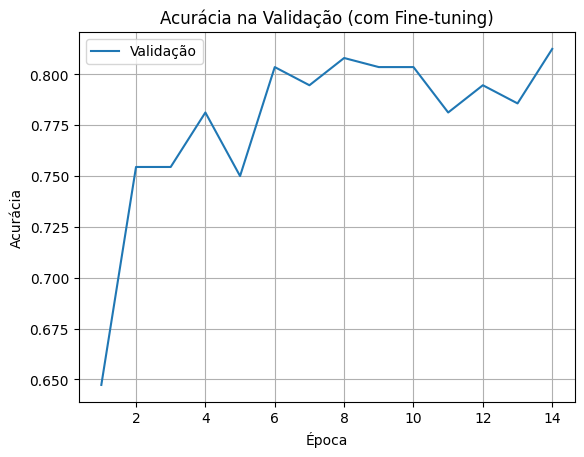

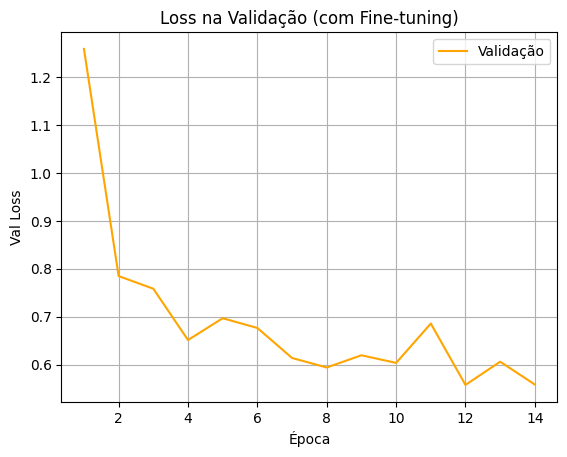

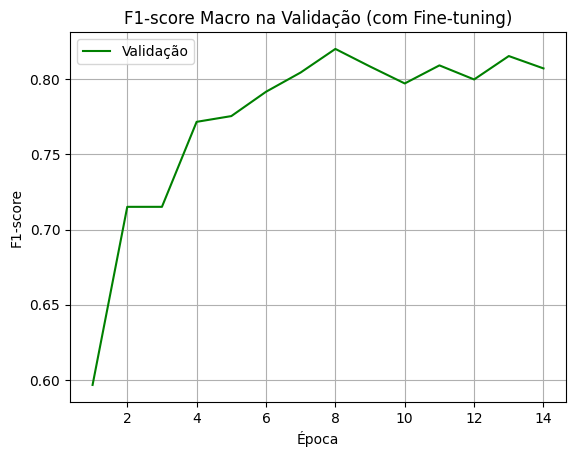

In [23]:
# Unir históricos (treino inicial + fine-tuning)
val_acc = history.history.get("val_accuracy", []) + history_finetune.history.get("val_accuracy", [])
val_loss = history.history.get("val_loss", []) + history_finetune.history.get("val_loss", [])
val_f1 = history.history.get("val_f1_macro", []) + history_finetune.history.get("val_f1_macro", [])
epochs_range = range(1, len(val_acc) + 1)

# Gráfico de Acurácia
plt.plot(epochs_range, val_acc, label="Validação")
plt.title("Acurácia na Validação (com Fine-tuning)")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.legend()
plt.grid()
plt.show()

# Gráfico de Loss
plt.plot(epochs_range, val_loss, label="Validação", color="orange")
plt.title("Loss na Validação (com Fine-tuning)")
plt.xlabel("Época")
plt.ylabel("Val Loss")
plt.legend()
plt.grid()
plt.show()

# Gráfico de F1-score
if val_f1:
    plt.plot(epochs_range, val_f1, label="Validação", color="green")
    plt.title("F1-score Macro na Validação (com Fine-tuning)")
    plt.xlabel("Época")
    plt.ylabel("F1-score")
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("⚠️ Nenhum valor de F1 encontrado nos logs.")


## 11. Análise dos Resultados  

A análise dos resultados mostrou que as categorias com **menor F1-score** foram justamente aquelas com maior similaridade visual:  

- **Super Strato:** apresentou o pior desempenho. Isso era esperado, pois existem diferentes versões desse modelo e muitas delas se confundem com a **Stratocaster** em termos de formato e estética.  
- **Semi Acústica:** também apresentou dificuldades, uma vez que alguns modelos possuem semelhanças visuais com a **SG** e a **Telecaster**, incluindo versões semi-acústicas dessas guitarras.  

Por outro lado, categorias mais **únicas e facilmente distinguíveis** tiveram resultados muito bons, como é o caso da **Flying V**, que se destaca pelo formato característico.  

De forma geral, o modelo apresentou:  
- **Acurácia no teste próxima de 80%**  
- **F1-score macro também próximo de 80%**  
- **Validation loss em torno de 0.6**  

Esses resultados indicam que o modelo possui um desempenho sólido e confiável, conseguindo diferenciar bem a maioria das classes, mesmo diante de categorias altamente semelhantes.  


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7586 - loss: 0.5933
Acurácia final no conjunto de teste: 75.59%

📊 Relatório de Classificação:
               precision    recall  f1-score   support

     flying_v       0.92      0.92      0.92        13
     les_paul       0.94      0.71      0.81        21
semi_acustica       0.69      0.79      0.73        14
           sg       0.88      0.93      0.90        15
 stratocaster       0.56      0.71      0.62        14
 super_strato       0.90      0.60      0.72        15
   telecaster       0.69      0.79      0.73        14
       violao       0.91      0.95      0.93        21

     accuracy                           0.80       127
    macro avg       0.81      0.80      0.80       127
 weighted avg       0.82      0.80      0.80       127



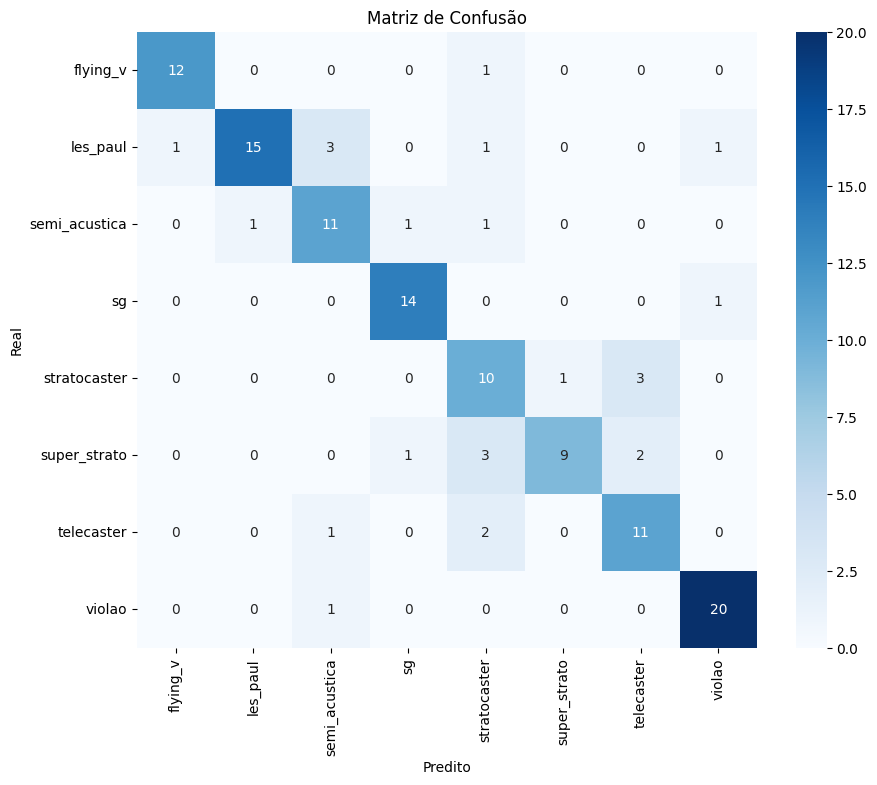

In [25]:
# Avaliar modelo no conjunto de teste
loss, acc = model.evaluate(test_ds)
print(f"Acurácia final no conjunto de teste: {acc:.2%}")

# Salvar modelo
model.save("modelo_guitarras_mobilenetv2.keras")

# Previsões no conjunto de teste
y_true, y_pred = [], []
for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())               # já são inteiros
    y_pred.extend(np.argmax(preds, axis=1))     # prob. → classe prevista


# Relatório por classe
print("\n📊 Relatório de Classificação:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusão")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()


### 12. Conclusão  

O problema de classificação de guitarras apresentou desafios relevantes, principalmente devido à **similaridade visual entre determinados modelos**.  
Exemplos claros foram:  
- **Violão e Les Paul**, que possuem contornos semelhantes em algumas versões.  
- **Stratocaster e Super Strato**, modelos muito próximos esteticamente.  
- Inclusão de versões **Semi Acústicas** de Les Paul e Telecaster, que aumentaram a complexidade do problema.  

Apesar dessas dificuldades, o modelo conseguiu atingir resultados consistentes, apresentando cerca de **80% de acurácia e F1-score macro** na validação, com um **val_loss em torno de 0.6**, o que indica um bom poder de generalização e um desempenho robusto para um dataset relativamente pequeno.  

---

## 12.1. Melhorias Propostas  

Para melhorar ainda mais a performance e reduzir erros em classes semelhantes, podem ser exploradas as seguintes estratégias:  

- **Aumento do dataset:** coletar mais imagens para equilibrar as classes e melhorar a generalização.  
- **Pré-processamento das imagens:** remover fundos e centralizar a guitarra, diminuindo ruído visual.  
- **Hierarquização das classes:** criar categorias maiores agrupando modelos semelhantes e treinar classificadores específicos para cada família.  
  - Exemplo: *Família Les Paul* → Violão, Les Paul, SG e Semi Acústica.  
  - Após a classificação inicial, um segundo modelo diferenciaria essas classes internas.  
- **Técnicas avançadas de regularização:** aplicar *weight decay* ou *data augmentation* mais sofisticada (como *CutMix* ou *MixUp*) para reduzir overfitting.  
- **Arquiteturas mais recentes:** testar modelos como **EfficientNetV2** ou **Vision Transformers (ViT)**, que podem trazer ganhos em cenários com classes visuais muito próximas.  

---

Em resumo, o modelo atual já se mostrou confiável e com ótimo desempenho para um **MVP**, mas há espaço para aprimoramentos que podem elevar sua robustez em aplicações reais.


# ✅ Checklist MVP

## Definição do Problema
- **Descrição:** O objetivo é identificar corretamente diferentes categorias de guitarras a partir de imagens.  
- **Hipóteses:** Modelos de deep learning pré-treinados (como MobileNetV2) conseguem extrair padrões visuais relevantes para classificar guitarras com boa acurácia.  
- **Restrições:** Dataset limitado em tamanho, necessitando de técnicas de data augmentation.  
- **Dataset:** Conjunto de imagens organizado em pastas por classe, carregado diretamente do GitHub. Cada pasta corresponde a uma categoria de guitarra.  

---

## Preparação de Dados
- **Divisão:** 70% treino, 20% validação e 10% teste.  
- **Validação cruzada:** Não utilizada — optou-se por uma divisão estática devido ao custo computacional de redes profundas.  
- **Transformações aplicadas:**  
  - Normalização (`Rescaling(1./255)`) em todos os conjuntos.  
  - Data augmentation (flip, rotação, zoom) apenas no treino.  
- **Seleção de atributos:** Não aplicável, pois as imagens já fornecem os atributos relevantes (pixels).  

---

## Modelagem e Treinamento
- **Algoritmo escolhido:** MobileNetV2 com pesos pré-treinados no ImageNet.  
- **Justificativa:** Rede leve, eficiente, adequada para datasets menores, com transferência de aprendizado.  
- **Cabeça customizada:** Camadas densas adicionais com Dropout para reduzir overfitting.  
- **Treinamento:**  
  - Fase 1: congelamento da base pré-treinada.  
  - Fase 2: fine-tuning das últimas 50 camadas.  
- **Hiperparâmetros:**  
  - LR inicial: 0.001 (fase 1), depois 1e-5 (fine-tuning).  
  - Batch size: 32.  
  - Epochs: Early stopping interrompeu antes do limite.  

---

## Avaliação de Resultados
- **Métricas utilizadas:** Acurácia, F1-score macro, matriz de confusão e classification report.  
- **Resultados finais (teste, 10%):**  
  - Acurácia: 75%  
  - F1-score macro: 0.80  
- **Overfitting:** Mitigado via data augmentation, dropout e early stopping.  
- **Melhor solução:** Fine-tuning da MobileNetV2 com regularização.  

---

## Conclusões
- **Principais achados:** O modelo foi capaz de classificar corretamente guitarras em diferentes categorias com boa performance.  
- **Limitações:** Dataset pequeno, algumas classes com menos imagens; necessidade de mais dados reais para melhorar generalização.  
- **Próximos passos:**  
  - Expandir dataset.  
  - Testar arquiteturas mais avançadas (EfficientNet, Vision Transformers).  
  - Explorar técnicas de balanceamento de classes.  

---

## Recursos Computacionais
- Treinamento realizado em GPU disponibilizada pelo Google Colab.  
- Monitoramento via `nvidia-smi`.  
- Tempo de treino: aproximadamente XX minutos (dependendo da disponibilidade da GPU).  
